# Netflix dataset preprocessing

In [2]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
import os
import sys

In [55]:
# Set directory of the netflix prize dataset
DATA_DIR = "./netflix-prize-data"

In [56]:
# Skip date
df1 = pd.read_csv(os.path.join(DATA_DIR, 'combined_data_1.txt'), header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [19]:
df2 = pd.read_csv(os.path.join(DATA_DIR, 'combined_data_2.txt'), header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv(os.path.join(DATA_DIR, 'combined_data_3.txt'), header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv(os.path.join(DATA_DIR, 'combined_data_4.txt'), header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

Dataset 2 shape: (26982302, 2)
Dataset 3 shape: (22605786, 2)
Dataset 4 shape: (26851926, 2)


In [20]:
# load less data for speed

df = df1
df = df1.append(df2)
df = df.append(df3)
df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (100498277, 2)
-Dataset examples-
           Cust_Id  Rating
0               1:     NaN
5000000    2560324     4.0
10000000   2271935     2.0
15000000   1921803     2.0
20000000   1933327     3.0
25000000   1465002     3.0
30000000    961023     4.0
35000000   1372532     5.0
40000000    854274     5.0
45000000    116334     3.0
50000000    768483     3.0
55000000   1331144     5.0
60000000   1609324     2.0
65000000   1699240     3.0
70000000   1776418     4.0
75000000   1643826     5.0
80000000    932047     4.0
85000000   2292868     4.0
90000000    932191     4.0
95000000   1815101     3.0
100000000   872339     4.0


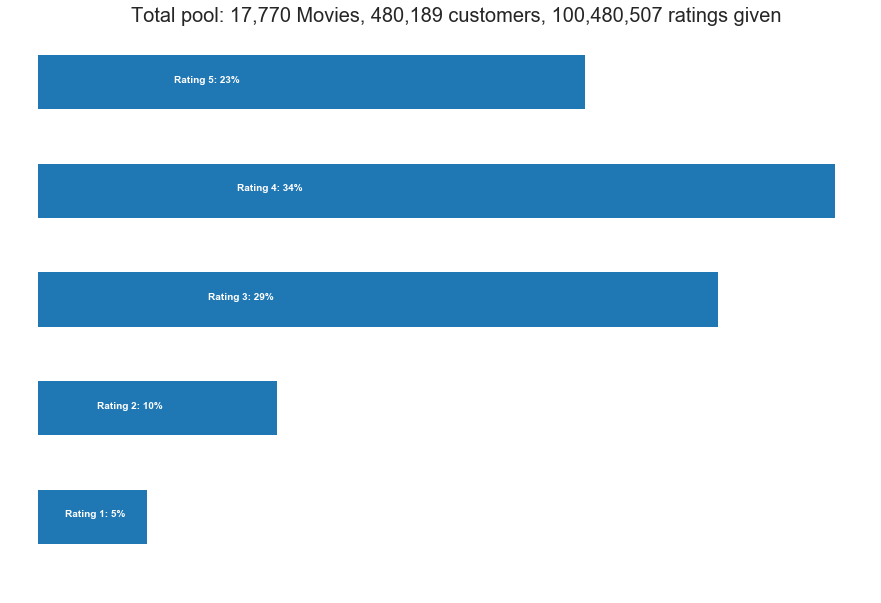

In [21]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [22]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 1.777e+04 1.777e+04 1.777e+04]
Length: 100480507


In [23]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
           Cust_Id  Rating  Movie_Id
1          1488844     3.0         1
5000996     501954     2.0       996
10001962    404654     5.0      1962
15002876    886608     2.0      2876
20003825   1193835     2.0      3825
25004661   1899206     3.0      4661
30005496    154804     4.0      5496
35006274   2078749     5.0      6274
40007057    450763     5.0      7057
45007991    102092     3.0      7991
50009023    220298     5.0      9023
55010042    550530     5.0     10042
60011038    222570     3.0     11038
65011875   1273080     5.0     11875
70012676   2026970     5.0     12676
75013582    506044     4.0     13582
80014453    353605     2.0     14453
85015116    664606     3.0     15116
90016008   2213715     3.0     16008
95016879   1589401     5.0     16879
100017627  2314006     4.0     17627


In [24]:
# binarize the data (only keep ratings >= 4)
df = df[df['Rating'] > 3.5]

In [25]:
df = df[['Cust_Id', 'Movie_Id', 'Rating']]
df.columns = ['userId', 'movieId', 'rating']
df.head()

,userId,movieId,rating
2,822109,1,5.0
3,885013,1,4.0
4,30878,1,4.0
7,124105,1,4.0
9,1842128,1,4.0


In [26]:
raw_data = df
raw_data.head()

,userId,movieId,rating
2,822109,1,5.0
3,885013,1,4.0
4,30878,1,4.0
7,124105,1,4.0
9,1842128,1,4.0


In [27]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [28]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

Only keep users who have watched at least 5 movies

In [29]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data, min_uc=5, min_sc=0)

In [30]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 56880037 watching events from 463435 users and 17769 movies (sparsity: 0.691%)


In [31]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [32]:
# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = 40000

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [33]:
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

In [34]:
unique_sid = pd.unique(train_plays['movieId'])

In [35]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [36]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [37]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [38]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled
14000 users sampled
15000 users sampled
16000 users sampled
17000 users sampled
18000 users sampled
19000 users sampled
20000 users sampled
21000 users sampled
22000 users sampled
23000 users sampled
24000 users sampled
25000 users sampled
26000 users sampled
27000 users sampled
28000 users sampled
29000 users sampled
30000 users sampled
31000 users sampled
32000 users sampled
33000 users sampled
34000 users sampled
35000 users sampled
36000 users sampled
37000 users sampled
38000 users sampled
39000 users sampled


In [39]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [40]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled
14000 users sampled
15000 users sampled
16000 users sampled
17000 users sampled
18000 users sampled
19000 users sampled
20000 users sampled
21000 users sampled
22000 users sampled
23000 users sampled
24000 users sampled
25000 users sampled
26000 users sampled
27000 users sampled
28000 users sampled
29000 users sampled
30000 users sampled
31000 users sampled
32000 users sampled
33000 users sampled
34000 users sampled
35000 users sampled
36000 users sampled
37000 users sampled
38000 users sampled
39000 users sampled


### Save the data into (user_index, item_index) format

In [47]:
pro_dir = "./"

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [49]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [50]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [51]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [52]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [53]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [54]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)